In [ ]:
!pip install SoundFile transformers scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

Epoch 1, Validation Loss: 0.0975302504375577, Validation Accuracy: 0.98
Epoch 2, Validation Loss: 0.0975302504375577, Validation Accuracy: 0.98
Epoch 3, Validation Loss: 0.0975302504375577, Validation Accuracy: 0.98
Epoch 4, Validation Loss: 0.0975302504375577, Validation Accuracy: 0.98
Epoch 5, Validation Loss: 0.0975302504375577, Validation Accuracy: 0.98
Predicting...
Predicted label: 1


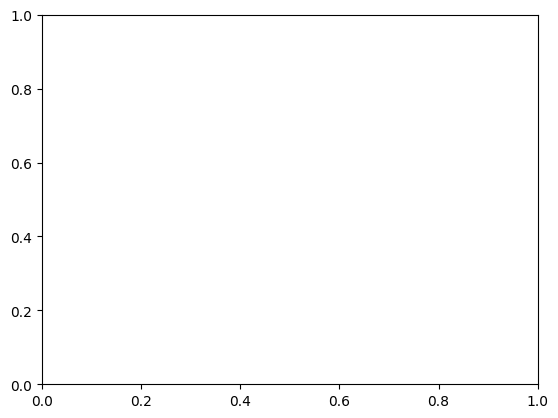

In [ ]:
import os
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split
# Custom Dataset class
class DysarthriaDataset(Dataset):
    def __init__(self, data, labels, max_length=100000):
        self.data = data
        self.labels = labels
        self.max_length = max_length
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav_data, _ = sf.read(self.data[idx])
        inputs = self.processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if self.max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((self.max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:self.max_length]

        # Remove unsqueezing the channel dimension
        # input_values = input_values.unsqueeze(0)

        # label = torch.zeros(32,dtype=torch.long)
        # label[self.labels[idx]] = 1

        ### CHANGES: simply return the label as a single integer
        return {"input_values": input_values}, self.labels[idx]
        ###


def train(model, dataloader, criterion, optimizer, device, ax, loss_vals, x_vals, fig,train_loader,epochs):
    model.train()
    running_loss = 0

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(**inputs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # append loss value to list
        loss_vals.append(loss.item())
        running_loss += loss.item()

        if (i+1) % 10 == 0:
            # update plot
            ax.clear()
            ax.set_xlim([0, len(train_loader)*epochs])
            ax.set_xlabel('Training Iterations')
            ax.set_ylim([0, max(loss_vals) + 2])
            ax.set_ylabel('Loss')
            ax.plot(x_vals[:len(loss_vals)], loss_vals)
            fig.canvas.draw()
            plt.pause(0.001)

    avg_loss = running_loss / len(dataloader)
    print(avg_loss)
    print("\n")
    return avg_loss



def main():
    dysarthria_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/training"
    non_dysarthria_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/training"

    dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
    non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

    data = dysarthria_files + non_dysarthria_files
    labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

    train_dataset = DysarthriaDataset(train_data, train_labels)
    test_dataset = DysarthriaDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=8, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)
    validation_loader = DataLoader(test_dataset, batch_size=8, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
    # model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

    ### NEW CODES
    # It seems like the classifier layer is excluded from the model's forward method (i.e., model(**inputs)).
    # That's why the number of labels in the output was 32 instead of 2 even when you had already changed the classifier.
    # Instead, huggingface offers the option for loading the Wav2Vec model with an adjustable classifier head on top (by setting num_labels).

    model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)
    ###
    model_path = "/content/dysarthria_classifier.pth"
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
    dysarthria_validation_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation"
    non_dysarthria_validation_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/validation"

    dysarthria_validation_files = [os.path.join(dysarthria_validation_path, f) for f in os.listdir(dysarthria_validation_path) if f.endswith('.wav')]
    non_dysarthria_validation_files = [os.path.join(non_dysarthria_validation_path, f) for f in os.listdir(non_dysarthria_validation_path) if f.endswith('.wav')]

    validation_data = dysarthria_validation_files + non_dysarthria_validation_files
    validation_labels = [1] * len(dysarthria_validation_files) + [0] * len(non_dysarthria_validation_files)

    epochs = 5
    fig, ax = plt.subplots()
    x_vals = np.arange(len(train_loader)*epochs)
    loss_vals = []
    nume = 1
    for epoch in range(epochs):
        ##train_loss = train(model, train_loader, criterion, optimizer, device, ax, loss_vals, x_vals, fig, train_loader, nume)
        ##print(f"Epoch {epoch + 1}, Train Loss: {train_loss}")

        val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy:.2f}")
        nume = nume+1

    torch.save(model.state_dict(), "dysarthria_classifier.pth")
    print("Predicting...")
    # Test on a specific audio file
    audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
    predicted_label = predict(model, audio_file, train_dataset.processor, device)
    print(f"Predicted label: {predicted_label}")

def predict(model, file_path, processor, device, max_length=100000): ### CHANGES: added max_length as an argument.
    model.eval()
    with torch.no_grad():
        wav_data, _ = sf.read(file_path)
        inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
        # inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}

        ### NEW CODES HERE
        input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
        if max_length - input_values.shape[-1] > 0:
            input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
        else:
            input_values = input_values[:max_length]
        input_values = input_values.unsqueeze(0).to(device)
        inputs = {"input_values": input_values}
        ###

        logits = model(**inputs).logits
        # _, predicted = torch.max(logits, dim=0)

        ### NEW CODES HERE
        # Remove the batch dimension.
        logits = logits.squeeze()
        predicted_class_id = torch.argmax(logits, dim=-1).item()
        ###

    # return predicted.item()
    return predicted_class_id
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            logits = model(**inputs).logits
            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

if __name__ == "__main__":
    main()


## DEBUGGING

In [ ]:
dysarthria_path = "/content/drive/MyDrive/torgo_data/dysarthria_male/training"
non_dysarthria_path = "/content/drive/MyDrive/torgo_data/non_dysarthria_male/training"

dysarthria_files = [os.path.join(dysarthria_path, f) for f in os.listdir(dysarthria_path) if f.endswith('.wav')]
non_dysarthria_files = [os.path.join(non_dysarthria_path, f) for f in os.listdir(non_dysarthria_path) if f.endswith('.wav')]

data = dysarthria_files + non_dysarthria_files
labels = [1] * len(dysarthria_files) + [0] * len(non_dysarthria_files)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_dataset = DysarthriaDataset(train_data, train_labels)
test_dataset = DysarthriaDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, drop_last=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(device)
# model.classifier = nn.Linear(model.config.hidden_size, 2).to(device)

model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=2).to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'projector.bias', 'wav2vec2.masked_spec_embed', 'classifier.weight', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
max_length = 100_000
processor = train_dataset.processor

model.eval()
audio_file = "/content/drive/MyDrive/torgo_data/dysarthria_male/validation/M01_Session1_0005.wav"
# predicted_label = predict(model, audio_file, train_dataset.processor, device)
# print(f"Predicted label: {predicted_label}")

wav_data, _ = sf.read(audio_file)
inputs = processor(wav_data, sampling_rate=16000, return_tensors="pt", padding=True)
input_values = inputs.input_values.squeeze(0)  # Squeeze the batch dimension
if max_length - input_values.shape[-1] > 0:
    input_values = torch.cat([input_values, torch.zeros((max_length - input_values.shape[-1],))], dim=-1)
else:
    input_values = input_values[:max_length]

input_values = input_values.unsqueeze(0).to(device)
input_values.shape

torch.Size([1, 100000])

In [ ]:
with torch.no_grad():
  outputs = model(**{"input_values": input_values})
  logits = outputs.logits

In [ ]:
input_values.shape, logits.shape

(torch.Size([1, 100000]), torch.Size([1, 2]))

In [ ]:
import torch.nn.functional as F
# Remove the batch dimension.
logits = logits.squeeze()
predicted_class_id = torch.argmax(logits, dim=-1)
predicted_class_id

tensor(0, device='cuda:0')